<a href="https://colab.research.google.com/github/james811223/Association-Rules-Mining/blob/master/Relax%20Inc.%20Take-Home%20Challenge/Relax_Inc_Take_Home_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data is available as two attached CSV files:  
takehome_user_engagement.csv  
takehome_users.csv  
The data has the following two tables:  
1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:  
* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:  
○ PERSONAL_PROJECTS: invited to join another user's personal workspace  
○ GUEST_INVITE: invited to an organization as a guest(limited permissions)  
○ ORG_INVITE: invited to an organization (as a full member)  
○ SIGNUP: signed up via the website  
○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)  
* creation_time: when they created their account
* last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
* enabled_for_marketing_drip: whether they are on the regular
marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).
2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.  
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.
We suggest spending 12 hours on this, but you're welcome to spend more or less.  
Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

# Set up

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC as svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score as cvs
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

In [60]:
sns.set_style('darkgrid', {'figure.facecolor': 'lightblue'})

In [28]:
user = pd.read_csv('http://www.sharecsv.com/dl/8a6f251a04513b0d44dcf02cd1546641/takehome_users.csv', 
                   encoding = 'ISO-8859-1', parse_dates = ['creation_time'])
usage = pd.read_csv('https://raw.githubusercontent.com/james811223/Data/master/takehome_user_engagement.csv', parse_dates = ['time_stamp'])

# Data wrangling

Get ids of adopted users.

In [46]:
adopted_id = []
for id in tqdm(user.object_id.unique()):
    time_stamp = usage.query('user_id == @id').time_stamp.to_list()
    if len(time_stamp) > 2:
        i = 0
        while 1 == 1:
            try:
                if (time_stamp[i + 2] - time_stamp[i]).days < 8:
                    adopted_id += [id]
                    break
            except:
                break
            i += 1

100%|██████████| 12000/12000 [00:48<00:00, 244.96it/s]


Add adopted column indicating user is adopted or not.

In [48]:
user['adopted'] = user.object_id.isin(adopted_id)
user.adopted = user.adopted.astype(int)

Extract features and target columns.

In [49]:
X = user[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']].copy()
y = user.adopted.copy()

Check missing values

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          6417 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 468.9+ KB


In [51]:
print(X[X.invited_by_user_id.notnull()].creation_source.unique())
X[X.invited_by_user_id.isnull()].creation_source.unique()

['GUEST_INVITE' 'ORG_INVITE']


array(['SIGNUP', 'PERSONAL_PROJECTS', 'SIGNUP_GOOGLE_AUTH'], dtype=object)

All missing values from invited_by_user_id column are missing because they did not join by invitation.

Fill missing value with string "drop".

In [52]:
X.fillna('drop', inplace = 1 == 1)

Check data types

In [53]:
X.dtypes

creation_source               object
opted_in_to_mailing_list       int64
enabled_for_marketing_drip     int64
org_id                         int64
invited_by_user_id            object
dtype: object

Convert org_id and invited_by_user_id to string.

In [54]:
X = X.astype({'org_id': str})

# EDA

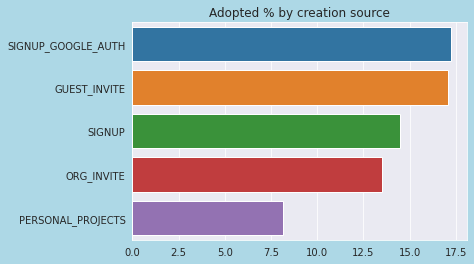

In [63]:
tdf = (user.groupby('creation_source').mean()['adopted'].sort_values(ascending = 1 == 2) * 100).reset_index()
sns.barplot('adopted', 'creation_source', data = tdf)
plt.ylabel('')
plt.xlabel('')
p = plt.title('Adopted % by creation source')

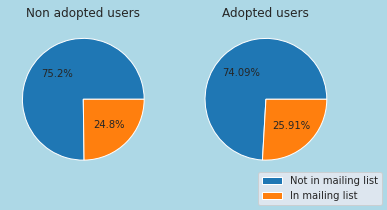

In [103]:
fig, ax = plt.subplots(1, 2, figsize = (6, 3))
tdf = user.groupby(['adopted', 'opted_in_to_mailing_list']).count()['name'].reset_index()
ax[0].pie('name', data = tdf.query('adopted == 0'), autopct = lambda x: str(round(x, 2)) + '%')
ax[0].set_title('Non adopted users')
ax[1].pie('name', data = tdf.query('adopted == 1'), autopct = lambda x: str(round(x, 2)) + '%')
fig.legend(['Not in mailing list', 'In mailing list'], loc = 'lower right')
p = ax[1].set_title('Adopted users')

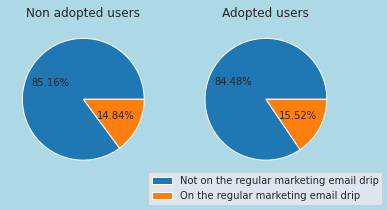

In [104]:
fig, ax = plt.subplots(1, 2, figsize = (6, 3))
tdf = user.groupby(['adopted', 'enabled_for_marketing_drip']).count()['name'].reset_index()
ax[0].pie('name', data = tdf.query('adopted == 0'), autopct = lambda x: str(round(x, 2)) + '%')
ax[0].set_title('Non adopted users')
ax[1].pie('name', data = tdf.query('adopted == 1'), autopct = lambda x: str(round(x, 2)) + '%')
fig.legend(['Not on the regular marketing email drip', 'On the regular marketing email drip'], loc = 'lower right')
p = ax[1].set_title('Adopted users')

# Modeling

In [111]:
y.value_counts(1 == 1)

0    0.862
1    0.138
Name: adopted, dtype: float64

The data is highly imbalanced with only 13.8% of adopted users.

One hot encoding

In [106]:
X = pd.get_dummies(X).drop(columns = ['invited_by_user_id_drop'])

Split data to training and testing set

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

Test a few models with default settings using CV F1 score with weighting.

In [142]:
scores = [cvs(RandomForestClassifier(class_weight = 'balanced'), X_train, y_train, scoring = 'f1', cv = 3).mean()]
scores += [cvs(svm(class_weight = 'balanced'), X_train, y_train, scoring = 'f1', cv = 3).mean()]
scores += [cvs(LogisticRegression(class_weight = 'balanced'), X_train, y_train, scoring = 'f1', cv = 3).mean()]
pd.DataFrame({'Model': ['Random Forest', 'SVM', 'Logistic Regression'], 'CV F1': scores})

,Model,CV F1
0,Random Forest,0.117303
1,SVM,0.213287
2,Logistic Regression,0.225169


The scores are too low.

Test the models again with default settings using CV F1 score with under sampling technique.

In [ ]:
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X_train, y_train)

In [137]:
scores = [cvs(RandomForestClassifier(), X_resampled, y_resampled, scoring = 'f1', cv = 3).mean()]
scores += [cvs(svm(), X_resampled, y_resampled, scoring = 'f1', cv = 3).mean()]
scores += [cvs(LogisticRegression(), X_resampled, y_resampled, scoring = 'f1', cv = 3).mean()]
pd.DataFrame({'Model': ['Random Forest', 'SVM', 'Logistic Regression'], 'CV F1': scores})

,Model,CV F1
0,Random Forest,0.563490
1,SVM,0.531419
2,Logistic Regression,0.546704


Hyper parameters tuning

In [164]:
params = {'criterion': ['gini', 'entropy'],
          'min_samples_split': [10, 20, 50, 100, 150], 'max_features': ['sqrt', 'log2']}
model = RandomizedSearchCV(RandomForestClassifier(), params, cv = 3, scoring = 'f1').fit(X_resampled, y_resampled)

Model performance

In [165]:
model.best_score_

0.5665043687077884

The model doesn't seem to improve much with hyper parameter tuning.

In [168]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67      3414
           1       0.16      0.55      0.25       546

    accuracy                           0.54      3960
   macro avg       0.52      0.55      0.46      3960
weighted avg       0.78      0.54      0.61      3960



# Important features

In [173]:
scores = model.best_estimator_.feature_importances_
scores = pd.DataFrame({'Feature': X.columns, 'Importance Score': scores}).sort_values('Importance Score', ascending = 1 == 2)

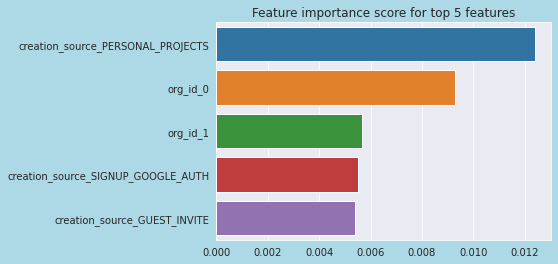

In [176]:
tdf = scores.head()
sns.barplot(y = 'Feature', x = 'Importance Score', data = tdf)
plt.ylabel('')
plt.xlabel('')
_ = plt.title('Feature importance score for top 5 features')

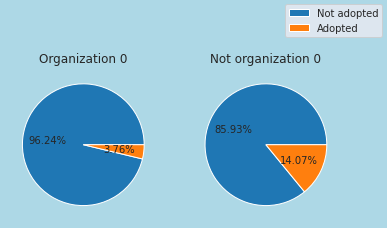

In [197]:
fig, ax = plt.subplots(1, 2)
tdf = user[['org_id', 'adopted']].copy()
ax[0].pie('org_id', autopct = lambda x: str(round(x, 2)) + '%', 
        data = tdf.query('org_id == 0').groupby('adopted').count().reset_index())
ax[0].set_title('Organization 0')
ax[1].pie('org_id', autopct = lambda x: str(round(x, 2)) + '%', 
        data = tdf.query('org_id != 0').groupby('adopted').count().reset_index())
ax[1].set_title('Not organization 0')
_ = fig.legend(['Not adopted', 'Adopted'])

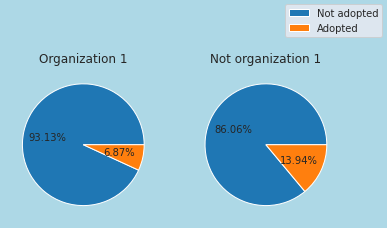

In [198]:
fig, ax = plt.subplots(1, 2)
tdf = user[['org_id', 'adopted']].copy()
ax[0].pie('org_id', autopct = lambda x: str(round(x, 2)) + '%', 
        data = tdf.query('org_id == 1').groupby('adopted').count().reset_index())
ax[0].set_title('Organization 1')
ax[1].pie('org_id', autopct = lambda x: str(round(x, 2)) + '%', 
        data = tdf.query('org_id != 1').groupby('adopted').count().reset_index())
ax[1].set_title('Not organization 1')
_ = fig.legend(['Not adopted', 'Adopted'])